<a href="https://colab.research.google.com/github/E-Juliet/Movie-reccomender/blob/main/phase_4_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Reccomender System

## Business Understanding

### Problem Statement

Cinemy,a movie streaming company asked there users to rate them on google play store. The feedback received was that the movies recommended to the users didn't match their interests thus most customers were dissatisfied. 

They have approached us, a data analytics company to help them solve their problem. We will therefore, build a movie recommender system that will aid in suggesting top 5 movies to the streaming site users based on their ratings  and the genres they prefer.

###Objectives

__Main Objective__

* To build a movie recommender system,to suggest top movies to the streaming users based on the movie ratings and genres prefered

__Specific objectives__
* To find out the average rating of movies
* To determine the number of movies per genre
* To determine the most popular movies


### Metric for sucess

We will use RMSE as our metric for success,the model having the lowest RMSE score being our best model.

### Data Understanding

The data used has been sourced from MovieLens dataset from the GroupLens research lab at the University of Minnesota.

It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users.

The dataset is distributed among four csv files:

* links.csv

* movies.csv

* ratings.csv

* tags.csv

__1.Movies.csv__

Each line of this file after the header row represents one movie, and has the following columns:

* movieId: Unique id for each movie
* title: Name of movies followed by their year of release
* genres: categories that a movie might fall into separated by |

__2.Links.csv__

The file `links.csv` contains indentifiers that can be used to link this data to other data sources like IMDb. Each line of this file after the header row represents one imdb link, and has the following columns:

* movieId: Unique id for each movie as used by https://movielens.org.
* imdbId: Unique id for each movie as used by http://www.imdb.com.
* tmdbId: Unique id for each movie as used by https://www.themoviedb.org.

__3.Tags.csv.__

 Each line of this file after the header row represents one tag applied to one movie by one user, and has the following columns:
* userId: Unique id for each user
movieId: Unique id for each movie
* tag: User-generated metadata about the movie in forms of short meaningful phrases
* timestamp: Time when tag was provided by user

__4.Ratings.csv__

Each line of this file after the header row represents one rating, and has the following columns:
* userId: Unique id for each user
* movieId: Unique id for each movie
* rating: Rating given by userId for movieId. Ratings are made on a 5-star scale with 0.5 increments.
* timestamp: Time when rating was given



In [44]:
# importing necessary libraries
import pandas as pd
import numpy as np
import random
import pickle

# installing surprise and importing some of its needed modules
!pip install surprise
from surprise import Dataset, Reader, SVD
from surprise.prediction_algorithms import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, knns, SVDpp
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


# setting the font size for all plots
font = {'size': 16}

plt.rc('font', **font)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# Reading the different data sets into pandas dataframe
tags_df = pd.read_csv('/content/drive/MyDrive/data/tags.csv')
movies_df = pd.read_csv('/content/drive/MyDrive/data/movies.csv')
ratings_df = pd.read_csv('/content/drive/MyDrive/data/ratings.csv')
links_df = pd.read_csv('/content/drive/MyDrive/data/links.csv')


### Reading the data

### links_df

In [47]:
#Checking the first five rows of the data and the data types.
display(links_df.head())
links_df.info()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


The links dataframe contains a movieid and also its id in imdb and tmbd. Both the movieId and imdbId are integers while tmdbId is a float.

### movies_df

In [48]:
#Checking the first five rows and the data types.
display(movies_df.head())
movies_df.info()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


movies df contains the movie id and also it's title plus the genre a certain movie belongs to.
The are no null values present here.

### ratings_df

In [49]:
display(ratings_df.head())
ratings_df.info()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


The rating df contains a user id, movie id and the ranking. Timestap here is irrelevant.

### tags_df

In [50]:
#Displaying the first 5 rows and checking for the data types.
display(tags_df.head())
tags_df.info()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


The tags df contains the user id, movie id and also its tag.There are no null values in this dataset.

In [51]:
# printing the number of records in every dataframe
dataframes = [links_df, movies_df, ratings_df, tags_df]
dataframe_names = ['links_df', 'movies_df', 'ratings_df', 'tags_df']

for i in range(len(dataframes)):
    print(f" {dataframe_names[i]} has {dataframes[i].shape[0]} records.")

 links_df has 9742 records.
 movies_df has 9742 records.
 ratings_df has 100836 records.
 tags_df has 3683 records.


tags_df has less values hence won't be appropriate to use it in this project. Also the same information present here is the same in the movie_df

## Data Cleaning
This section involves dropping columns that wont be used in the project. The relevant dataframs will be merged eventually.

### movie_df
**the genres column**

The values in the genres column will be changes to lower case and stored in a list.

In [52]:
#Making the letters in genres column lowercase and storing them in a list.
movies_df_cleaned = movies_df.copy()
movies_df_cleaned.genres = movies_df.genres.map(lambda x: x.replace('|', ',').lower().split(','))
movies_df_cleaned

,movieId,title,genres
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"
1,2,Jumanji (1995),"[adventure, children, fantasy]"
2,3,Grumpier Old Men (1995),"[comedy, romance]"
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]"
4,5,Father of the Bride Part II (1995),[comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[action, animation, comedy, fantasy]"
9738,193583,No Game No Life: Zero (2017),"[animation, comedy, fantasy]"
9739,193585,Flint (2017),[drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[action, animation]"


### ratings_df, tags_df

**Removing the timestamp columns in both dataframes**

In [53]:
#Dropping timestamp column
ratings_df_cleaned = ratings_df.drop('timestamp', axis=1)
tags_df_cleaned = tags_df.drop('timestamp', axis=1)

display(ratings_df_cleaned.head(2))
tags_df_cleaned.head(2)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0


,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable


This dataset has a total of 20 movie genres.

## EDA - Explanatory Data Analysis

### Biraviate Data Analysis

#### Movies made per year

In [54]:
# extracting years from the title column
movies_df_cleaned['year'] = movies_df_cleaned['title'].str.extract('.*\((.*)\).*',expand = False)
movies_df_cleaned.year.unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '2005', '2006', '1902', nan, '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', '2006–2007'], dtype=object)

There seems to be an off value ('2006--2007') and also a nan value

In [55]:
# checking record(s) that have 2006--2007 in the year column
movies_df_cleaned[movies_df_cleaned['year'] == "2006–2007"]

,movieId,title,genres,year
9518,171749,Death Note: Desu nôto (2006–2007),[(no genres listed)],2006–2007


In [56]:
# changing it to 2007
movies_df_cleaned.year = movies_df_cleaned.year.replace('2006–2007', '2007')
movies_df_cleaned[movies_df_cleaned['year'] == "2006–2007"]

,movieId,title,genres,year


In [57]:
# checking record(s) that contain null values in the year column
display(movies_df_cleaned[pd.isna(movies_df_cleaned.year)])
len(movies_df_cleaned[pd.isna(movies_df_cleaned.year)])

,movieId,title,genres,year
6059,40697,Babylon 5,[sci-fi],NaN
9031,140956,Ready Player One,"[action, sci-fi, thriller]",NaN
9091,143410,Hyena Road,[(no genres listed)],NaN
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,[(no genres listed)],NaN
9179,149334,Nocturnal Animals,"[drama, thriller]",NaN
9259,156605,Paterson,[(no genres listed)],NaN
9367,162414,Moonlight,[drama],NaN
9448,167570,The OA,[(no genres listed)],NaN
9514,171495,Cosmos,[(no genres listed)],NaN
9515,171631,Maria Bamford: Old Baby,[(no genres listed)],NaN


12

In [58]:
#Getting the first year

print(movies_df_cleaned['year'].dropna().astype(int).min())

#Getting the latest year 
print(movies_df_cleaned['year'].dropna().astype(int).max())




1902
2018


In [59]:

movies_df_cleaned['year']=movies_df_cleaned['year'].dropna().astype(int)


In [60]:
movies_df_cleaned

,movieId,title,genres,year
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",1995.0
1,2,Jumanji (1995),"[adventure, children, fantasy]",1995.0
2,3,Grumpier Old Men (1995),"[comedy, romance]",1995.0
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]",1995.0
4,5,Father of the Bride Part II (1995),[comedy],1995.0
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[action, animation, comedy, fantasy]",2017.0
9738,193583,No Game No Life: Zero (2017),"[animation, comedy, fantasy]",2017.0
9739,193585,Flint (2017),[drama],2017.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[action, animation]",2018.0


In [61]:
#Binning  the years in groups of 10
movies_df_cleaned['year_bins'] = pd.cut(x=movies_df_cleaned['year'], bins=list(range(1900,2018,10)))
movies_df_cleaned



,movieId,title,genres,year,year_bins
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",1995.0,"(1990.0, 2000.0]"
1,2,Jumanji (1995),"[adventure, children, fantasy]",1995.0,"(1990.0, 2000.0]"
2,3,Grumpier Old Men (1995),"[comedy, romance]",1995.0,"(1990.0, 2000.0]"
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]",1995.0,"(1990.0, 2000.0]"
4,5,Father of the Bride Part II (1995),[comedy],1995.0,"(1990.0, 2000.0]"
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[action, animation, comedy, fantasy]",2017.0,NaN
9738,193583,No Game No Life: Zero (2017),"[animation, comedy, fantasy]",2017.0,NaN
9739,193585,Flint (2017),[drama],2017.0,NaN
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[action, animation]",2018.0,NaN


This dataset contains movie released between year 1902 and 2018.

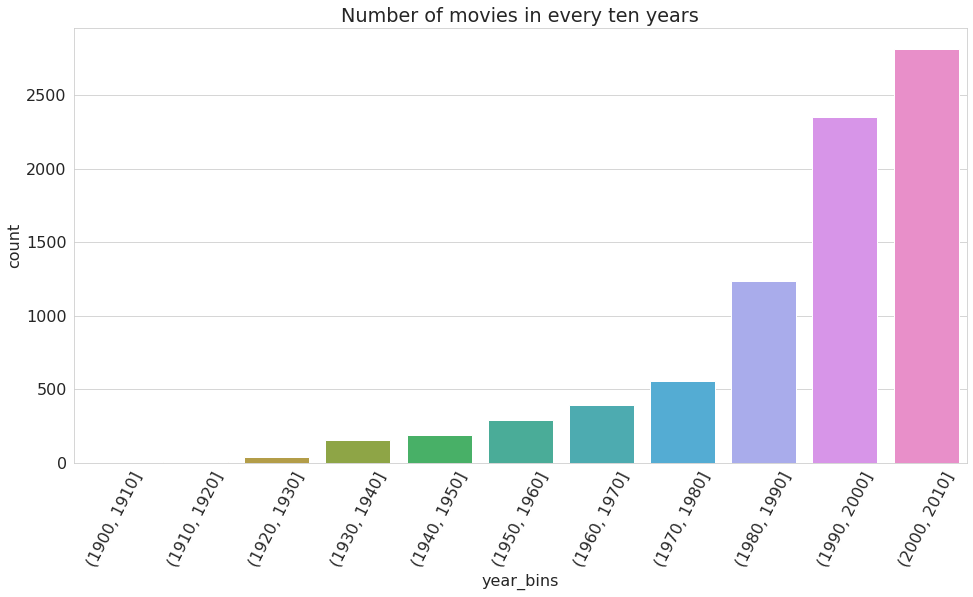

In [62]:
#Plotting the number of movies released every 10 years between 1902 and 2018.
plt.figure(figsize=(16,8))
sns.countplot(x=movies_df_cleaned.year_bins.dropna())
plt.xticks(rotation=63)
plt.title('Number of movies in every ten years')
plt.show()

From the graph above, the number of movies produced increases over the years. the highest number of movies produced was between 2000 and 2010.

#### Movies rating counts

In [63]:
#Calculating the mean of ratings.
ratings_df_cleaned['rating'].mean()

3.501556983616962

The ratings seem to range from 0 to 5 with 5 being the best rating and 0 being the worst.

In [64]:
# investigating the range of ratings in the ratings df
ratings_df_cleaned['rating'].value_counts().to_frame()

,rating
4.0,26818
3.0,20047
5.0,13211
3.5,13136
4.5,8551
2.0,7551
2.5,5550
1.0,2811
1.5,1791
0.5,1370


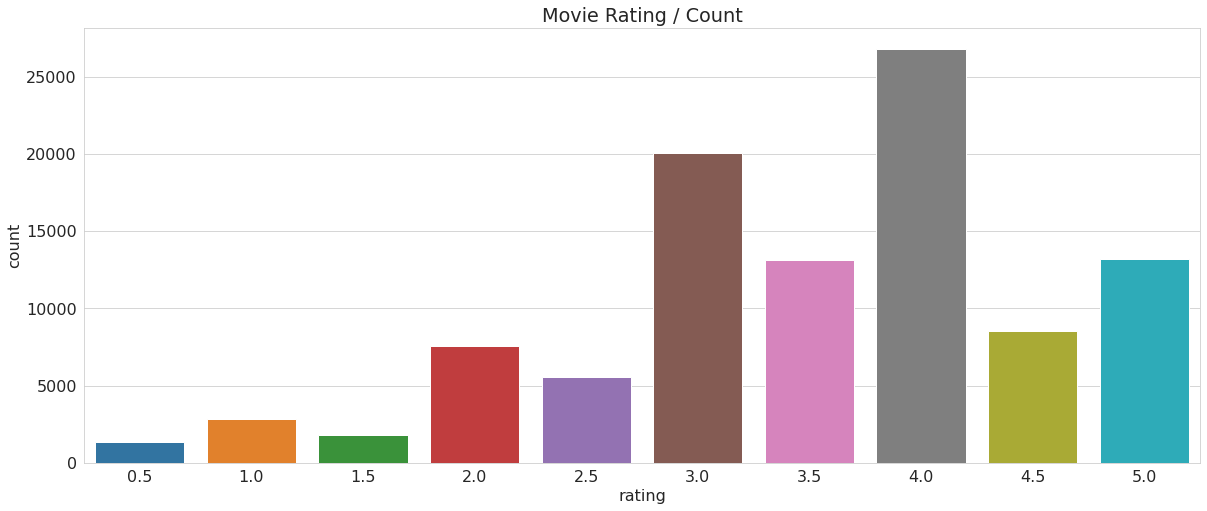

In [65]:
# Plotting a count plot of the ratings
plt.figure(figsize=(20,8))
sns.countplot(x=ratings_df_cleaned['rating'])
plt.title('Movie Rating / Count');
plt.show()

From the plot above, most movies were rated above average (3.5):.It can be deduced that rating given by users approximately 3.0 - 4.0 is the most common rating in the dataset. Also it seems to follow some kind of a normal distribution although there are some outliers

### Genre average ratings

**Getting all the genres present in the dataset**

In [66]:
# creating a list to store the movie genres
genres = []

for record in range(len(movies_df_cleaned)):
    genres_list = movies_df_cleaned.loc[record, 'genres']

    for genre in genres_list:
        if genre not in genres:
            genres.append(genre)

In [67]:
genres_list = genres

In [68]:
#  creating a df to store the average ratings of every genre
genre_ratings_records = pd.DataFrame(index=genres, columns=['ratings'], data=np.zeros(len(genres)))
genre_ratings_records['no_records'] = np.zeros(len(genres))

for genre in genres:
    # iterating through every record to
    ratings = []
    no_records = 0
    for record in range(movies_df_cleaned.shape[0]):
        genres = movies_df_cleaned.loc[record, 'genres']

        if genre in genres:
            movie_id = movies_df_cleaned.loc[record, 'movieId']

            # fetching the ratings from the ratings df
            ratings.append(ratings_df[ratings_df.movieId == movie_id]['rating'].mean())
            no_records+=1
            

    genre_ratings_records.loc[genre, 'ratings'] = np.mean(ratings)
    genre_ratings_records.loc[genre, 'no_records'] = no_records

genre_ratings_sorted = genre_ratings_records
genre_ratings_sorted.head()

,ratings,no_records
adventure,NaN,1263.0
animation,NaN,611.0
children,3.10769,664.0
comedy,NaN,3756.0
fantasy,NaN,779.0


### Total movies per genre

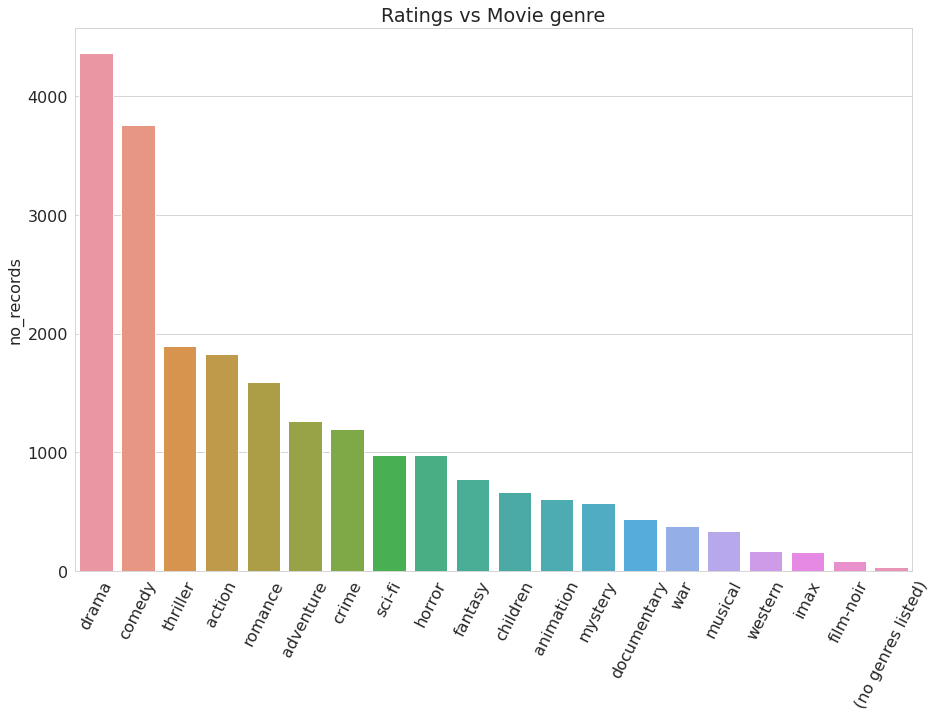

In [69]:
# printing the popularity of the genres in ascending order.
plt.figure(figsize=(15,10))
sns.barplot(x=genre_ratings_sorted.sort_values('no_records', ascending=False).index, y=genre_ratings_sorted.sort_values('no_records', ascending=False).no_records)
plt.xticks(rotation=63)
plt.title('Ratings vs Movie genre')
plt.show()

The most rated genre is drama. It is seen to be the most popular as mystery is the least popular with a lower rating count.

In [70]:
# returning the movies_df_cleaned 
movies_df_cleaned.drop(['year','year_bins'], axis=1, inplace=True)

### Making a master dataframe
We will merge different data frames to make a harmonised dataframe containing appropriate data. First lets have a look at the dataframes and how they can be merged together based on the criterions available.

In [71]:
#Viewing the shape of  the movies_df dataset.
movies_df_cleaned.shape

(9742, 3)

In [72]:
#Checcking for the number of null values in movies_df
movies_df_cleaned.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [73]:
# movies with no ratings receive 0 as their average rating
mean_rating = ratings_df_cleaned.groupby('movieId').rating.mean().rename('mean rating')
num_rating = ratings_df_cleaned.groupby('movieId').userId.count().rename('num rating')

In [74]:
#Viewing the first 5 rows of cleaned ratings dataset.
ratings_df_cleaned.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [75]:
#Converting the mean rating to dataframe
test_mean= pd.DataFrame(mean_rating, index= movies_df_cleaned.movieId)

In [76]:
#Converting the num rating to a dataframe
test_num = pd.DataFrame(num_rating, index= movies_df_cleaned.movieId)

In [77]:
#Merging mean rating and num rating 
test_final = pd.merge(test_mean, test_num, on= "movieId")
test_final.head()

,mean rating,num rating
movieId,,
1,3.920930,215.0
2,3.431818,110.0
3,3.259615,52.0
4,2.357143,7.0
5,3.071429,49.0


In [78]:
#Merging the cleaned df with the ratings
df_final= pd.merge(movies_df_cleaned, test_final, on= "movieId")
df_final.head()

,movieId,title,genres,mean rating,num rating
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.920930,215.0
1,2,Jumanji (1995),"[adventure, children, fantasy]",3.431818,110.0
2,3,Grumpier Old Men (1995),"[comedy, romance]",3.259615,52.0
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]",2.357143,7.0
4,5,Father of the Bride Part II (1995),[comedy],3.071429,49.0


In [79]:
#Checking for null values
df_final.isna().sum()

movieId         0
title           0
genres          0
mean rating    18
num rating     18
dtype: int64

In [80]:
#Checking for the null values in out dataset 
df_final[df_final["num rating"].isna()]

,movieId,title,genres,mean rating,num rating
816,1076,"Innocents, The (1961)","[drama, horror, thriller]",NaN,NaN
2211,2939,Niagara (1953),"[drama, thriller]",NaN,NaN
2499,3338,For All Mankind (1989),[documentary],NaN,NaN
2587,3456,"Color of Paradise, The (Rang-e khoda) (1999)",[drama],NaN,NaN
3118,4194,I Know Where I'm Going! (1945),"[drama, romance, war]",NaN,NaN
4037,5721,"Chosen, The (1981)",[drama],NaN,NaN
4506,6668,"Road Home, The (Wo de fu qin mu qin) (1999)","[drama, romance]",NaN,NaN
4598,6849,Scrooge (1970),"[drama, fantasy, musical]",NaN,NaN
4704,7020,Proof (1991),"[comedy, drama, romance]",NaN,NaN
5020,7792,"Parallax View, The (1974)",[thriller],NaN,NaN


There are null values in our final dataset. Therefore, we will go ahead to drop them.

In [81]:
# dropping the null values
df_final.dropna(inplace= True)

In [82]:
# setting movie_id to be the index

df_final.set_index('movieId', inplace=True)

In [83]:
#Cgecking for the shape of our final dataset.
df_final.shape

(9724, 4)

#### One hot encoding the genres column
 We will one hot encode the genres column to make it easier to iterate through.

In [84]:
#Checking the first 5 rows of our final dataset.
df_final.head()

,title,genres,mean rating,num rating
movieId,,,,
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.920930,215.0
2,Jumanji (1995),"[adventure, children, fantasy]",3.431818,110.0
3,Grumpier Old Men (1995),"[comedy, romance]",3.259615,52.0
4,Waiting to Exhale (1995),"[comedy, drama, romance]",2.357143,7.0
5,Father of the Bride Part II (1995),[comedy],3.071429,49.0


In [85]:
#Ten most popular movies
popular = df_final.sort_values(by=['num rating'], ascending=False).head(10)
popular

,title,genres,mean rating,num rating
movieId,,,,
356,Forrest Gump (1994),"[comedy, drama, romance, war]",4.164134,329.0
318,"Shawshank Redemption, The (1994)","[crime, drama]",4.429022,317.0
296,Pulp Fiction (1994),"[comedy, crime, drama, thriller]",4.197068,307.0
593,"Silence of the Lambs, The (1991)","[crime, horror, thriller]",4.161290,279.0
2571,"Matrix, The (1999)","[action, sci-fi, thriller]",4.192446,278.0
260,Star Wars: Episode IV - A New Hope (1977),"[action, adventure, sci-fi]",4.231076,251.0
480,Jurassic Park (1993),"[action, adventure, sci-fi, thriller]",3.750000,238.0
110,Braveheart (1995),"[action, drama, war]",4.031646,237.0
589,Terminator 2: Judgment Day (1991),"[action, sci-fi]",3.970982,224.0


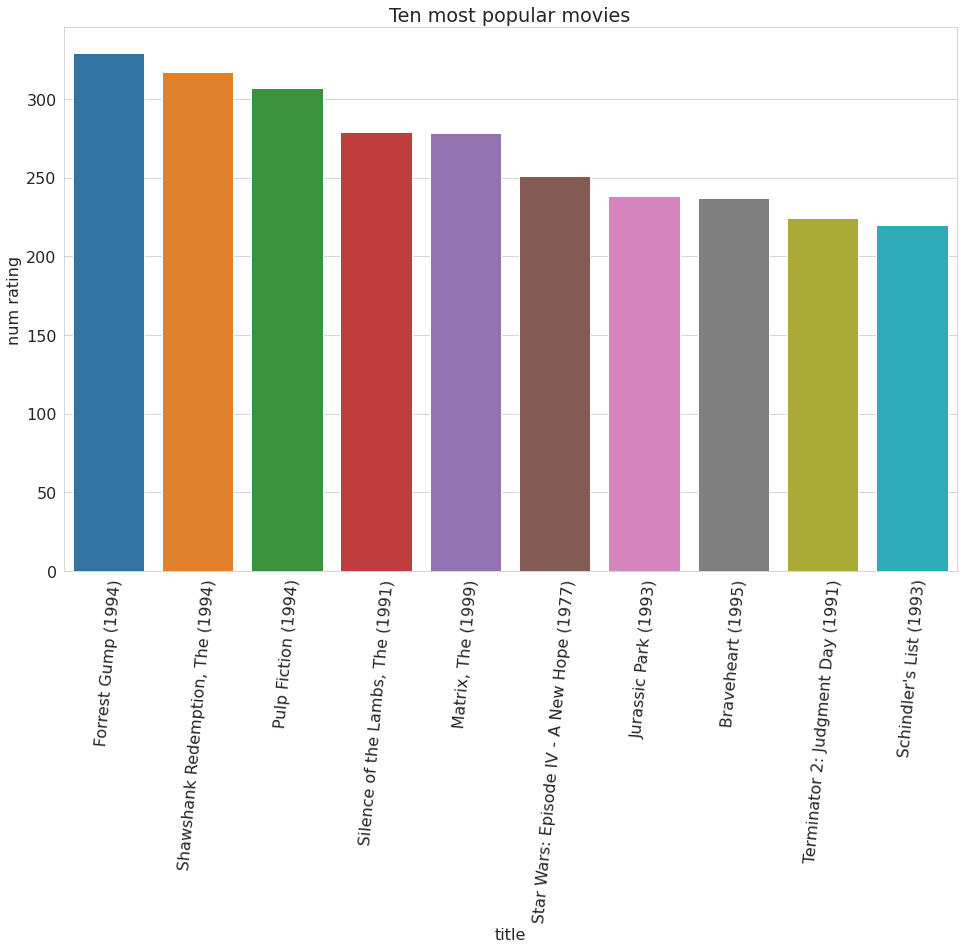

In [86]:
# Plotting ten most popular movies
plt.figure(figsize=(16,10))
sns.barplot(x=popular.title, y=popular['num rating'])
plt.xticks(rotation=85)
plt.title("Ten most popular movies")
plt.show()
#plt.savefig("Ten most popular movies")

The most popular movie from the above plot is Forrest Gump(1994) with 329 ratings.

In [87]:
# selecting columns to be used for one hot encoding
genres_columns = genres_list[0:-1]

# creating genres columns and filling them with zeros
for genre in genres_columns:
    df_final[genre] = np.zeros(len(df_final))

# filling the genre columns with a 1 if the record exist and a 0 if the record does not exist
for movieId in df_final.index:
    rec_genres = df_final.loc[movieId, 'genres']

    for genre in rec_genres:
        df_final.loc[movieId, genre] = 1

In [88]:
# dropping the '(no genres listed)' column
df_final.drop('(no genres listed)', axis=1, inplace=True)
df_final.head()

,title,genres,mean rating,num rating,adventure,animation,children,comedy,fantasy,romance,...,thriller,horror,mystery,sci-fi,war,musical,documentary,imax,western,film-noir
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.920930,215.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jumanji (1995),"[adventure, children, fantasy]",3.431818,110.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Grumpier Old Men (1995),"[comedy, romance]",3.259615,52.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Waiting to Exhale (1995),"[comedy, drama, romance]",2.357143,7.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Father of the Bride Part II (1995),[comedy],3.071429,49.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Investigating correlation between movies with higher number number of ratings and movies with average ratings

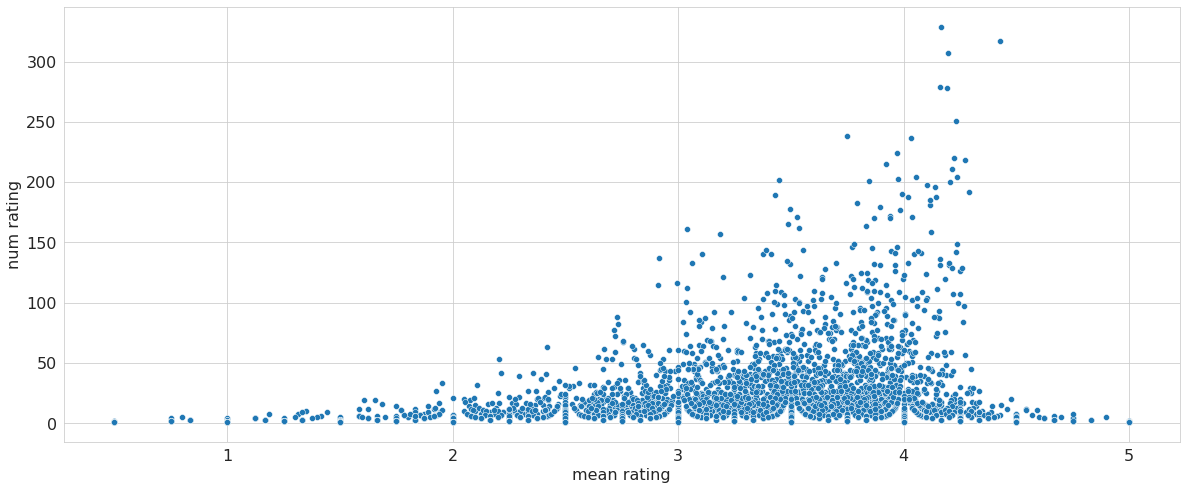

In [89]:
# mean rating and  total number of rating scatterplot
plt.figure(figsize=(20,8))
sns.scatterplot(data=df_final, x='mean rating', y ='num rating');

It can be deduced that movies that are good, also have a high number of ratings. Hence a correlation between the two.

## Naive Recommendation Engine

Naive Recommendation Engine will make use of the overall Ratings and genres in order to make movie recommendtions. This would be helpful especially when resolving Cold-start problem.
`Cold-start problem occurs when the system encounters new visitors to a website, with no browsing history or known preferences. creating a personalized experience for them becomes a challenge because the data normally used for generating recommendations is missing.`

`Solution`

For the first model we will recommend the top 10 most popular movies. i.e Movies with the most number of ratings that are highly rated.

In [90]:
#selecting specific columns from the final data frame.
#assign the columns to a new variable called user ratigs
user_ratings = df_final[['title', 'mean rating', 'num rating']]
user_ratings

,title,mean rating,num rating
movieId,,,
1,Toy Story (1995),3.920930,215.0
2,Jumanji (1995),3.431818,110.0
3,Grumpier Old Men (1995),3.259615,52.0
4,Waiting to Exhale (1995),2.357143,7.0
5,Father of the Bride Part II (1995),3.071429,49.0
...,...,...,...
193581,Black Butler: Book of the Atlantic (2017),4.000000,1.0
193583,No Game No Life: Zero (2017),3.500000,1.0
193585,Flint (2017),3.500000,1.0


In [91]:
#sort the new dataFrame by number of ratings from highest to lowest
#Top 10 movies by its number of ratings
user_ratings.sort_values(by=['num rating'], ascending=False).head(10)

,title,mean rating,num rating
movieId,,,
356,Forrest Gump (1994),4.164134,329.0
318,"Shawshank Redemption, The (1994)",4.429022,317.0
296,Pulp Fiction (1994),4.197068,307.0
593,"Silence of the Lambs, The (1991)",4.161290,279.0
2571,"Matrix, The (1999)",4.192446,278.0
260,Star Wars: Episode IV - A New Hope (1977),4.231076,251.0
480,Jurassic Park (1993),3.750000,238.0
110,Braveheart (1995),4.031646,237.0
589,Terminator 2: Judgment Day (1991),3.970982,224.0


The above dataFrame shows the movies with the highest number of Rating. Lets also analyse the movies with the highest rating.


In [92]:
# top 10 movies by its mean ratings
user_ratings.sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
movieId,,,
88448,Paper Birds (Pájaros de papel) (2010),5.0,1.0
100556,"Act of Killing, The (2012)",5.0,1.0
143031,Jump In! (2007),5.0,1.0
143511,Human (2015),5.0,1.0
143559,L.A. Slasher (2015),5.0,1.0
6201,Lady Jane (1986),5.0,1.0
102217,Bill Hicks: Revelations (1993),5.0,1.0
102084,Justice League: Doom (2012),5.0,1.0
6192,Open Hearts (Elsker dig for evigt) (2002),5.0,1.0


The above dataFrame does not provide very useful information the recomender since some movies might have only been rated by one user thus its average rating being 5. We have to also consider movies that have a higher average rating that have been rated by many users.

In the cell below we will analyse top 10 highly rated movies that have been rated by 200 users`200 num of ratings`

In [93]:
#creating minimum number of ratings
#find the most popular movies in the data frame.
threshold = 200
user_ratings[user_ratings['num rating']>threshold ].sort_values(by=['mean rating'], ascending=False).head(10)

,title,mean rating,num rating
movieId,,,
318,"Shawshank Redemption, The (1994)",4.429022,317.0
2959,Fight Club (1999),4.272936,218.0
50,"Usual Suspects, The (1995)",4.237745,204.0
260,Star Wars: Episode IV - A New Hope (1977),4.231076,251.0
527,Schindler's List (1993),4.225000,220.0
1196,Star Wars: Episode V - The Empire Strikes Back...,4.215640,211.0
296,Pulp Fiction (1994),4.197068,307.0
2571,"Matrix, The (1999)",4.192446,278.0
356,Forrest Gump (1994),4.164134,329.0


The dataframe above finaly gives the most popular movies which are also loved by most users.

To further refine our recommendations we will use Genre information from the final EDA dataFrame.` A user might want to be recommended a specific genre e.g Animation` Hence the need to refine the recommendation to the users preference

In [94]:
#using the final data frame from EDA
df_final.head()

,title,genres,mean rating,num rating,adventure,animation,children,comedy,fantasy,romance,...,thriller,horror,mystery,sci-fi,war,musical,documentary,imax,western,film-noir
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.920930,215.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jumanji (1995),"[adventure, children, fantasy]",3.431818,110.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Grumpier Old Men (1995),"[comedy, romance]",3.259615,52.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Waiting to Exhale (1995),"[comedy, drama, romance]",2.357143,7.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Father of the Bride Part II (1995),[comedy],3.071429,49.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
# selecting the top movies given a certain genre and number of rating threshold 
genre = 'animation'
rating_thresh = 200
df_final[(df_final[genre] == 1) & (df_final['num rating']>rating_thresh)].sort_values(by=['mean rating'], ascending=False).head(10)

,title,genres,mean rating,num rating,adventure,animation,children,comedy,fantasy,romance,...,thriller,horror,mystery,sci-fi,war,musical,documentary,imax,western,film-noir
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.92093,215.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Naive Recommendation for a new user**

Building the basic Recommendation Engine.

- For cases where there is no information for users, the recommender will recommend movies rated more than the set threshold with the highest rating.
- For cases where the user wants recommendation for specific genre, the recommender will recommend only movies from that specified genre that have the highest rating 

In [96]:
# function to return all top movies
def good_movies(threshold=10):
    return df_final[df_final['num rating']>rating_thresh ].sort_values(by=['mean rating'], ascending=False).iloc[:,0:4].head(threshold)

In [97]:
# function to recommend to a user certain movies given a certain genre
def recommender(genre, threshold=10):
    # getting the last record
    rating_thresh = list(df_final[ df_final[genre] == 1 ]['num rating'].to_frame().sort_values('num rating', ascending=False)['num rating'][:threshold*2])[-1]

    result = df_final[(df_final[genre] == 1) & (df_final['num rating']>=rating_thresh)].sort_values(by=['mean rating'], ascending=False).iloc[:,0:4].head(threshold)
    
    # print('\n\nThese are the recommendations for the users with the following filters')
    # print('Minimum number of ratings:',threshold)
    # print("User's choice of genre:",genre)
    # display(result)
    return result

In [98]:
def movie_recommender(genre=None, threshold=10):
    if genre:
        return recommender(genre,threshold)
    else:
        return good_movies(threshold)

In [99]:
movie_recommender()

,title,genres,mean rating,num rating
movieId,,,,
318,"Shawshank Redemption, The (1994)","[crime, drama]",4.429022,317.0
2959,Fight Club (1999),"[action, crime, drama, thriller]",4.272936,218.0
50,"Usual Suspects, The (1995)","[crime, mystery, thriller]",4.237745,204.0
260,Star Wars: Episode IV - A New Hope (1977),"[action, adventure, sci-fi]",4.231076,251.0
527,Schindler's List (1993),"[drama, war]",4.225000,220.0
1196,Star Wars: Episode V - The Empire Strikes Back...,"[action, adventure, sci-fi]",4.215640,211.0
296,Pulp Fiction (1994),"[comedy, crime, drama, thriller]",4.197068,307.0
2571,"Matrix, The (1999)","[action, sci-fi, thriller]",4.192446,278.0
356,Forrest Gump (1994),"[comedy, drama, romance, war]",4.164134,329.0


In [100]:
movie_recommender('sci-fi',5)

,title,genres,mean rating,num rating
movieId,,,,
260,Star Wars: Episode IV - A New Hope (1977),"[action, adventure, sci-fi]",4.231076,251.0
1196,Star Wars: Episode V - The Empire Strikes Back...,"[action, adventure, sci-fi]",4.215640,211.0
2571,"Matrix, The (1999)","[action, sci-fi, thriller]",4.192446,278.0
1210,Star Wars: Episode VI - Return of the Jedi (1983),"[action, adventure, sci-fi]",4.137755,196.0
1270,Back to the Future (1985),"[adventure, comedy, sci-fi]",4.038012,171.0


## Content-Based Recommender

A content based recommender works with data that the user provides, either explicitly `rating` or implicitly `clicking on a link`. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

In [101]:
ratings_df_cleaned.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [102]:
movies_df_cleaned.head()

,movieId,title,genres
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"
1,2,Jumanji (1995),"[adventure, children, fantasy]"
2,3,Grumpier Old Men (1995),"[comedy, romance]"
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]"
4,5,Father of the Bride Part II (1995),[comedy]


In [103]:
# merging ratings and movies data
df = pd.merge(ratings_df_cleaned, movies_df_cleaned, on = 'movieId')
df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"
1,5,1,4.0,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"
2,7,1,4.5,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"
3,15,1,2.5,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"
4,17,1,4.5,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"


In [104]:

ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num rating'] =pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num rating
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


- For this second Recommender Engine we will use correlation between the ratings assigned to different movies,in order to find the similarity between the movies.
- We created a matrix that has the `userID` on one axis and `movie title` on another axis.Each cell will then consist of the ratings the user gave to the movie.
- `NOTE` There are a lot of NAN values in the cells, because most people have not seen most of the movies

In [105]:
# creating a pivot table
movie_matrix = df.pivot_table(index='userId', columns= 'title',values='rating')
movie_matrix.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Most rated movies based on number of ratings

In [106]:
# top 5 movies with the most number of ratings
ratings.sort_values('num rating',ascending = False).head()

,rating,num rating
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278


We will choose the Matrix, The (1999) to use as an example. Imagine a user who has watched the Matrix, The (1999) movie and wants to be recommeneded a new movie to watch that is similar to the Matrix, The (1999)

First we find the ratings for the Matrix, The (1999) movie from the matrix created before

In [107]:
#finds the user ratings for the matrix movie from the movie matrix
movie_name = "Matrix, The (1999)"
matrix_user_ratings = movie_matrix[movie_name]
matrix_user_ratings .head()

userId
1    5.0
2    NaN
3    NaN
4    1.0
5    NaN
Name: Matrix, The (1999), dtype: float64

We then used the corrwith method in pandas to find movies that are similar to the matrix movie based on the user ratigs

In [108]:
# using correlation to find movies similar to the matrix
similar_to_matrix = movie_matrix.corrwith(matrix_user_ratings)
corr_matrix =  pd.DataFrame(similar_to_matrix, columns=['Correlation'])
#drop null values from the dataframe
corr_matrix.dropna(inplace=True)
corr_matrix.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
title,
"'burbs, The (1989)",-0.160843
(500) Days of Summer (2009),0.302316
*batteries not included (1987),0.392232
...And Justice for All (1979),0.654654
10 Cent Pistol (2015),-1.000000


In [109]:
#sort the values based on correlation with the matrix movie
corr_matrix.sort_values('Correlation',ascending = False).head(10)

,Correlation
title,
Haywire (2011),1.0
Highway 61 (1991),1.0
World on a Wire (Welt am Draht) (1973),1.0
"War Zone, The (1999)",1.0
"Hitcher, The (1986)",1.0
Gross Anatomy (a.k.a. A Cut Above) (1989),1.0
Paper Towns (2015),1.0
Juwanna Mann (2002),1.0
Topsy-Turvy (1999),1.0


The above dataFrame may be biased since some movies might have only been rated by only one user. Therefore we need to also consider number of ratings

In [110]:
#joining the number of rating colum to the above data frame
corr_with_matrix = corr_matrix.join(ratings['num rating'])
corr_with_matrix.head()

,Correlation,num rating
title,,
"'burbs, The (1989)",-0.160843,17
(500) Days of Summer (2009),0.302316,42
*batteries not included (1987),0.392232,7
...And Justice for All (1979),0.654654,3
10 Cent Pistol (2015),-1.000000,2


We can the get the most similar movies to the Matrix, The (1999) and recommend to the user.

In [111]:
#choosing a threshold of number of ratings to be considered 
#sort the data frame based on correltion and number of ratings
threshhold = 100
corr_with_matrix[corr_with_matrix['num rating']>threshhold].sort_values('Correlation',ascending = False).head()

,Correlation,num rating
title,,
"Matrix, The (1999)",1.000000,278
Die Hard (1988),0.544466,145
Inception (2010),0.514767,143
Braveheart (1995),0.496045,237
Aliens (1986),0.470865,126


## Implementing a Recommendation Engine using surprise library

In [112]:
# reading values as a surprise dataset
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(ratings_df_cleaned, reader)

# genreating a trainset
dataset = data.build_full_trainset()
print('Number of users:', dataset.n_users, '\n')
print('Number of items:', dataset.n_items)

Number of users: 610 

Number of items: 9724


We have fewer users compared to the number of items. We will take that into account, and prefer to use a user based reccomendation.

### Training Various models

In [113]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose= False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.879377,0.676182,3.504861,0.343140
KNNBaseline,0.883544,0.675158,0.212858,2.125571
KNNWithZScore,0.904786,0.686616,0.161251,1.898347
KNNWithMeans,0.905691,0.691819,0.111691,1.753157
KNNBasic,0.959587,0.736027,0.084133,1.694718


While SVDpp had the better performance in terms of error rate, it is very time consuming to train. A grid search on SVDpp will last for a long time. Therefore we will chose to optimize the SVD model for number of epochs, learning rate and regularization and the KNNBaseline model as well. This are so far our most promising models with lower error rates.

In [114]:
# We perform gridsearch using svd
param_grid = {"n_factors": [10, 20, 30, 40, 50, 60], "reg_all": [.02, .05, .1]}
grid_search = GridSearchCV(SVD, param_grid= param_grid)
grid_search.fit(data)

In [115]:
# printing out optimal parameters for the gridsearch
print("Optimal gridsearch params: ", grid_search.best_params)
print("")
print("Best scores: ", grid_search.best_score)

Optimal gridsearch params:  {'rmse': {'n_factors': 50, 'reg_all': 0.05}, 'mae': {'n_factors': 10, 'reg_all': 0.02}}

Best scores:  {'rmse': 0.869279251783649, 'mae': 0.668364775361799}


In [116]:
# using obtained optimals
param_grid= {"n_factors": [30], "reg_all":[.05], "n_epochs":[5, 10, 20, 30], "lr_all":[.0025, .005, .001, .01]}
grid_search = GridSearchCV(SVD, param_grid= param_grid)
grid_search.fit(data)

In [117]:
# printing out optimal parameters for the gridsearch
print("Optimal gridsearch params: ", grid_search.best_params)
print("")
print("Best scores: ", grid_search.best_score)

Optimal gridsearch params:  {'rmse': {'n_factors': 30, 'reg_all': 0.05, 'n_epochs': 20, 'lr_all': 0.01}, 'mae': {'n_factors': 30, 'reg_all': 0.05, 'n_epochs': 20, 'lr_all': 0.01}}

Best scores:  {'rmse': 0.8598841862344268, 'mae': 0.6599976862629847}


From above our best SVD model has the following parameters:
1. n_factors= 30
2. reg_all= .05
3. n_epochs= 20
4. lr_all= .01

Below we instantiate the model with this parameters

In [118]:
svd_final = SVD(n_factors= 30, reg_all= .05, n_epochs= 20, lr_all= .01)
svd_final.fit(dataset)

We tune the KNNBaseline model below

In [119]:
param_grid = {"k": list(range(5, 100, 5))}
grid_search_knn_base = GridSearchCV(KNNBaseline, param_grid= param_grid)
grid_search_knn_base.fit(data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [120]:
# printing out optimal parameters for the gridsearch
print("Optimal gridsearch params: ", grid_search_knn_base.best_params)
print("")
print("Best scores: ", grid_search_knn_base.best_score)

Optimal gridsearch params:  {'rmse': {'k': 30}, 'mae': {'k': 35}}

Best scores:  {'rmse': 0.875511408218783, 'mae': 0.6684421168182745}


Below we make a loop to iterate over the different parameters as we alternate between user based and item based recommendation.

In [121]:
method = ["cosine", "pearson", "pearson_baseline", "msd"]
user_base = [False, True]

for m in method:
  for u in user_base:
    knn_base = cross_validate(KNNBaseline(k= 30, sim_options= {"name":m, "user_based":u}, verbose= False), data, cv= 5)
    rmse_mean = np.mean(knn_base["test_rmse"])
    print(f"The mean rmse of the KNNBaseline model with {m} and user based {u} is {rmse_mean}")

The mean rmse of the KNNBaseline model with cosine and user based False is 0.8942997898669326
The mean rmse of the KNNBaseline model with cosine and user based True is 0.8790238452415211
The mean rmse of the KNNBaseline model with pearson and user based False is 0.8832583779436932
The mean rmse of the KNNBaseline model with pearson and user based True is 0.8779380480224559
The mean rmse of the KNNBaseline model with pearson_baseline and user based False is 0.8538673823526166
The mean rmse of the KNNBaseline model with pearson_baseline and user based True is 0.8785062591805994
The mean rmse of the KNNBaseline model with msd and user based False is 0.8702873806741479
The mean rmse of the KNNBaseline model with msd and user based True is 0.8749516540057811


The best performing model from above is the item based and uses the pearson_baseline method, we will instantiate the method below then fit it to the dataset. But, since we already have decided not to use an item based recommender, we will proceed with the SVD model.

In [122]:
knn_baseline_final = KNNBaseline(k= 30, sim_options= {"name": "pearson_baseline", "user_based": False})
knn_baseline_final.fit(dataset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Picking user 610, we will attempt to predict the rating the user will provide for Toy story 3 given how they highly rated Toy story.

In [123]:
# df_final[(df_final['userId'] == 610) & (df_final['movieId'] == 1)][['userId', 'movieId', 'rating', 'title']]
ratings_df_cleaned[(ratings_df_cleaned["userId"] == 1) & (ratings_df_cleaned["movieId"] == 1)]

,userId,movieId,rating
0,1,1,4.0


In [124]:
knn_baseline_final.predict(610, 78499)

Prediction(uid=610, iid=78499, r_ui=None, est=4.6114622486933605, details={'actual_k': 30, 'was_impossible': False})

We predict a rating of about 4.5 which is pretty high in the rating scale. We try the same using the SVD model:

In [125]:
svd_final.predict(610, 78499)

Prediction(uid=610, iid=78499, r_ui=None, est=4.499074695359367, details={'was_impossible': False})

A prediction of a rating of about 4.5, this indicates that both models could be performing the same, despite the different rmse scores.

In [126]:
ratings_df_cleaned.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [127]:
movies_df_cleaned.head()

,movieId,title,genres
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"
1,2,Jumanji (1995),"[adventure, children, fantasy]"
2,3,Grumpier Old Men (1995),"[comedy, romance]"
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]"
4,5,Father of the Bride Part II (1995),[comedy]


In [128]:
df_final.head(3)

,title,genres,mean rating,num rating,adventure,animation,children,comedy,fantasy,romance,...,thriller,horror,mystery,sci-fi,war,musical,documentary,imax,western,film-noir
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]",3.920930,215.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Jumanji (1995),"[adventure, children, fantasy]",3.431818,110.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Grumpier Old Men (1995),"[comedy, romance]",3.259615,52.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
# pickle the final model
filename = 'svd_final.sav'
pickle.dump(svd_final, open(filename, 'wb'))

In [130]:
# reloading the model
load_svd = pickle.load(open(filename, 'rb'))

In [131]:
# def get_movie_recommendations(user_id, preferred_genre = 'all',min_num_ratings= 50):
#   # df = df_final.copy()
    
#   # filtering out by genre
#   if preferred_genre !='all':
#     df = df_final[df_final[preferred_genre]==1]
#   # # filtering out by number of ratings
#   df = df_final[df_final['num rating']>=min_num_ratings]
  
#   # filtering out all movies already rated by user
#   movies_already_watched = set(df[df['userId']==user_id].movieId.values)
#   df= df[~df['movieId'].isin(movies_already_watched)]
    
#   # finding expected ratings for all remaining movies in the dataset
#   all_movie_ids = set(df['movieId'].values)
#   all_movie_ratings = []
    
#   for i in all_movie_ids:
#       expected_rating = svd_final.predict(uid=user_id, iid=i).est
#       all_movie_ratings.append((i,round(expected_rating,1)))
        
#   # # extracting top five movies by expected rating
#   expected_df = pd.DataFrame(all_movie_ratings, columns=['movieId','Expected Rating'])    
#   result_df = pd.merge(expected_df, df_final[['movieId','title','num rating']],on='movieId')
#   result_df = result_df.sort_values(['Expected Rating','num rating'],ascending=[False,False])
    
#   return result_df.head()

In [132]:
# receiving movie ratings for a given user id
# get_movie_recommendations(1, "action")

## Final Engine

In [133]:
def hybrid_recommendation_engine(user_id='new', preferred_genre=None, threshold=50):
    
    if user_id=='new':
        if preferred_genre:
            # result = df_final[(df_final['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)
            result = movie_recommender(threshold= threshold) 
        else:
            # result = df_final[(df_final[preferred_genre] == 1) & (movies_df['num rating']>minimum_num_ratings)].sort_values(by=['mean rating'], ascending=False).head(10)
            result = movie_recommender(preferred_genre, threshold= threshold)

    else:
        new_df = df_final.copy()

        rating_thresh = list(df_final[ df_final[genre] == 1 ]['num rating'].to_frame().sort_values('num rating', ascending=False)['num rating'][:threshold*2])[-1]
        # filtering out by genre
        if preferred_genre !='all':
            new_df = new_df[new_df[preferred_genre]==1]

        # filtering out by number of ratings
        new_df = new_df[new_df['num rating']>=rating_thresh]

        # filtering out all movies already rated by user
        movies_already_watched = set(ratings_df_cleaned[ratings_df_cleaned['userId']==user_id].movieId.values)
        new_df= new_df[~new_df.index.isin(movies_already_watched)]

        # finding expected ratings for all remaining movies in the dataset
        all_movie_ids = set(new_df.index)
        all_movie_ratings = []

        for i in all_movie_ids:
            expected_rating = load_svd.predict(uid=user_id, iid=i).est
            all_movie_ratings.append((i,round(expected_rating,1)))

        # extracting top five movies by expected rating
        expected_df = pd.DataFrame(all_movie_ratings, columns=['movieId','Expected Rating'])    
        result = pd.concat([expected_df, df_final[['title','num rating']]], axis= 1)
        result = result.sort_values(['num rating'],ascending= False)
        result.dropna(inplace= True)
        result = result.head()
    
    
    print('\n\nThese are the recommendations for the users with the following filters')
    print('User id:',user_id)
    print('Minimum number of ratings:',threshold)
    print("User's choice of genre:", preferred_genre)
    display(result)

In [134]:
hybrid_recommendation_engine()



These are the recommendations for the users with the following filters
User id: new
Minimum number of ratings: 50
User's choice of genre: None


,title,genres,mean rating,num rating
movieId,,,,
318,"Shawshank Redemption, The (1994)","[crime, drama]",4.429022,317.0
2959,Fight Club (1999),"[action, crime, drama, thriller]",4.272936,218.0
50,"Usual Suspects, The (1995)","[crime, mystery, thriller]",4.237745,204.0
260,Star Wars: Episode IV - A New Hope (1977),"[action, adventure, sci-fi]",4.231076,251.0
527,Schindler's List (1993),"[drama, war]",4.225000,220.0
1196,Star Wars: Episode V - The Empire Strikes Back...,"[action, adventure, sci-fi]",4.215640,211.0
296,Pulp Fiction (1994),"[comedy, crime, drama, thriller]",4.197068,307.0
2571,"Matrix, The (1999)","[action, sci-fi, thriller]",4.192446,278.0
356,Forrest Gump (1994),"[comedy, drama, romance, war]",4.164134,329.0


In [135]:
hybrid_recommendation_engine(610, "action")



These are the recommendations for the users with the following filters
User id: 610
Minimum number of ratings: 50
User's choice of genre: action


,movieId,Expected Rating,title,num rating
110,2826.0,3.1,Braveheart (1995),237.0
1,3593.0,2.1,Toy Story (1995),215.0
50,2167.0,3.5,"Usual Suspects, The (1995)",204.0
47,34405.0,4.1,Seven (a.k.a. Se7en) (1995),203.0
150,1387.0,4.1,Apollo 13 (1995),201.0


## Final Model
Finally we made a hybrid system which included the naive recommendation system to deal with the cold start problem and SVD model. The SVD model was chosen as it had the lowest RMSE at 0.85 which indicates a better accuracy compared to the other models. We also added filtering options for genre and minimum number of ratings so as to give the users some control over the recommendations.

## Recommendations
For a new user we could recommend movies of the drama genre as they were seen to the most popular and most loved by other users.
New users can also be recommended for a specific movie based on genre.

Despite the above recommendations there is still room to improve the engine further. We could include more data or do further tuning of hyperparameters. We could also try using neural networks.
